In [ ]:
import os
from glob import glob


dir_generated = r"C:\Users\golds\Desktop\Data-Driven Design\OpenAI_dataset\A_seamless_3D-embossed_floral__0"
dir_scraped   = r"C:\Users\golds\Desktop\Data-Driven Design\Pinterest_data\seamless_ornamental_pattern_0"


print("generate folders：", os.listdir(dir_generated))
print("scrape folders：", os.listdir(dir_scraped))


def find_images(root):
    exts = ("*.jpg","*.jpeg","*.png","*.JPG","*.PNG")
    out = []
    for e in exts:
        out += glob(os.path.join(root, "**", e), recursive=True)
    return out

api_imgs      = find_images(dir_generated)
unsplash_imgs = find_images(dir_scraped)

print(f"sample  {len(unsplash_imgs)} generate image {len(api_imgs)} ")


print("before scrape 5：", unsplash_imgs[:5])
print("before generate 5：", api_imgs[:5])


生成目录下一级文件/文件夹： ['A_seamless_3D-embossed_floral__0.png', 'A_seamless_3D-embossed_floral__1.png', 'A_seamless_3D-embossed_floral__10.png', 'A_seamless_3D-embossed_floral__11.png', 'A_seamless_3D-embossed_floral__12.png', 'A_seamless_3D-embossed_floral__13.png', 'A_seamless_3D-embossed_floral__14.png', 'A_seamless_3D-embossed_floral__15.png', 'A_seamless_3D-embossed_floral__16.png', 'A_seamless_3D-embossed_floral__17.png', 'A_seamless_3D-embossed_floral__18.png', 'A_seamless_3D-embossed_floral__19.png', 'A_seamless_3D-embossed_floral__2.png', 'A_seamless_3D-embossed_floral__20.png', 'A_seamless_3D-embossed_floral__21.png', 'A_seamless_3D-embossed_floral__22.png', 'A_seamless_3D-embossed_floral__23.png', 'A_seamless_3D-embossed_floral__24.png', 'A_seamless_3D-embossed_floral__25.png', 'A_seamless_3D-embossed_floral__26.png', 'A_seamless_3D-embossed_floral__27.png', 'A_seamless_3D-embossed_floral__28.png', 'A_seamless_3D-embossed_floral__29.png', 'A_seamless_3D-embossed_floral__3.png', 'A_s

爬虫样本：400 张，生成样本：149 张


提取特征: 100%|██████████| 549/549 [00:01<00:00, 313.88it/s]


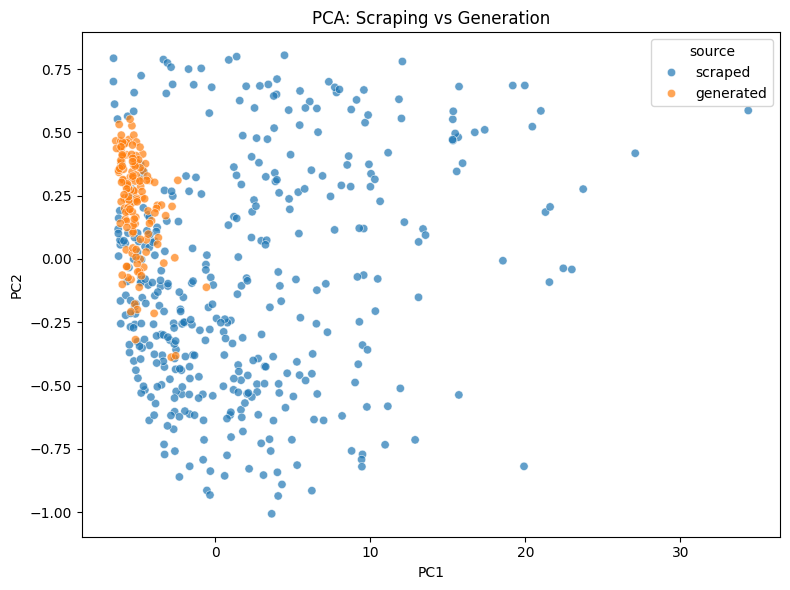

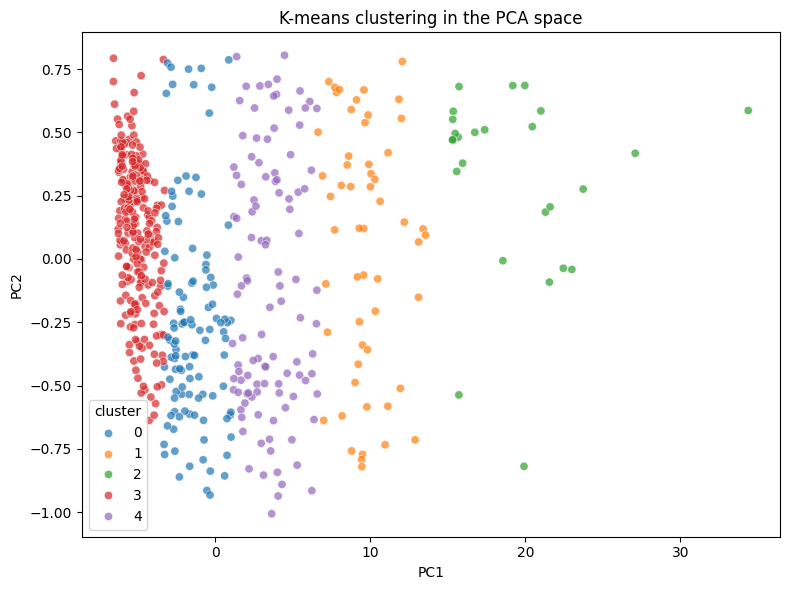

In [ ]:

# pip install opencv-python scikit-image matplotlib seaborn scikit-learn pandas tqdm python-dotenv

import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
from skimage.feature.texture import graycomatrix, graycoprops
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from dotenv import load_dotenv


dir_scraped   = r"C:\Users\golds\Desktop\Data-Driven Design\Pinterest_data\seamless_ornamental_pattern_0"
dir_generated = r"C:\Users\golds\Desktop\Data-Driven Design\OpenAI_dataset\A_seamless_3D-embossed_floral__0"


unsplash_imgs = glob(os.path.join(dir_scraped, "*.jpg"))
api_imgs      = glob(os.path.join(dir_generated, "*.png"))
all_imgs      = unsplash_imgs + api_imgs
labels        = ["scraped"] * len(unsplash_imgs) + ["generated"] * len(api_imgs)

print(f"scrape sample：{len(unsplash_imgs)} image：{len(api_imgs)} ")


def extract_hsv_hist(path, bins=(8,8,8)):
    img = cv2.imread(path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, bins, [0,180, 0,256, 0,256])
    return cv2.normalize(hist, hist).flatten()


def extract_glcm_feats(path, distances=[1], angles=[0]):
    gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img16 = (gray / 16).astype(np.uint8)
    glcm = graycomatrix(img16, distances, angles, levels=16, symmetric=True, normed=True)
    return [graycoprops(glcm, prop)[0,0] for prop in
            ('contrast','dissimilarity','homogeneity','energy','correlation')]


hsv_feats = []
glcm_feats = []
for p in tqdm(all_imgs, desc="提取特征"):
    hsv_feats.append(extract_hsv_hist(p))
    glcm_feats.append(extract_glcm_feats(p))
hsv_feats = np.array(hsv_feats)
glcm_feats = np.array(glcm_feats)


features = np.hstack([hsv_feats, glcm_feats])
columns = [f"hsv_{i}" for i in range(hsv_feats.shape[1])] + \
          [f"glcm_{i}" for i in range(glcm_feats.shape[1])]
df = pd.DataFrame(features, columns=columns)
df['source'] = labels

pca = PCA(n_components=2)
coords = pca.fit_transform(features)
df['PC1'], df['PC2'] = coords[:,0], coords[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='source', alpha=0.7)
plt.title('PCA: Scraping vs Generation')
plt.tight_layout()
plt.show()


kmeans = KMeans(n_clusters=5, random_state=42).fit(coords)
df['cluster'] = kmeans.labels_

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster', palette='tab10', alpha=0.7)
plt.title('K-means clustering in the PCA space')
plt.tight_layout()
plt.show()
